### Import Libraries 



In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import mlrose_hiive as mlrose
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Load the dataset



In [51]:
import pandas as pd

# Load the dataset
data = pd.read_csv("heart_cleveland_upload.csv")

In [52]:
# Display the first few rows
print(data.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


# Preprocess
### Since the dataset contains only numerical features, we need to scale the numerical features using StandardScaler from sklearn library. 
### We also need to split the dataset into input features (X) and output feature (y), where y is the "condition" column.


In [53]:
num_cols = data.select_dtypes(include="number").columns.tolist()
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
X = data.drop("condition", axis=1)
y = data["condition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define the fitness function for neural network weights
### We can experiment with different architectures and hyperparameters. Here we use a neural network architecture with 3 hidden layers, each with 64 neurons, and dropout regularization:


In [54]:
def nn_fitness_function(weights):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.set_weights(weights)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    score = model.evaluate(X_train, y_train, verbose=0)
    return -score[1]  # minimize the negative accuracy

### Define the optimization problems for the different algorithms

In [49]:
fitness_functions = [
    mlrose.OneMax(),
    mlrose.FlipFlop(),
    mlrose.FourPeaks(t_pct=0.1),
    mlrose.SixPeaks(),
    mlrose.Knapsack(weights=[1, 2, 3], values=[10, 20, 30], max_weight_pct=0.5)
]


### Define the search spaces for the different algorithms

In [55]:
search_space = {
    "length": 10,
    "fitness_fn": fitness_functions[3],
    "maximize": True,
    "mode": "max"
}


In [56]:
# Define algorithms
algorithms = [
    {
        "name": "Random Search",
        "function": mlrose.random_hill_climb,
        "kwargs": {"max_attempts": 100, "max_iters": 100, "restarts": 0, "curve": True},
        "fitness_function": fitness_functions[3],
        "search_space": {
            "length": 100
        }
    }
]

## Define the hyperparameters for simulated annealing

In [43]:
sa_hyperparameters = {"schedule": mlrose.ExpDecay()}

## Define the hyperparameters for genetic algorithm

In [44]:
ga_hyperparameters = {"pop_size": 200, "mutation_prob": 0.1}

## Define the hyperparameters for MIMIC

In [45]:
mimic_hyperparameters = {"pop_size": 200, "keep_pct": 0.2}

## Run the optimization algorithms and print results

## Run the algorithms and get the results

Random Search
{'length': 100}


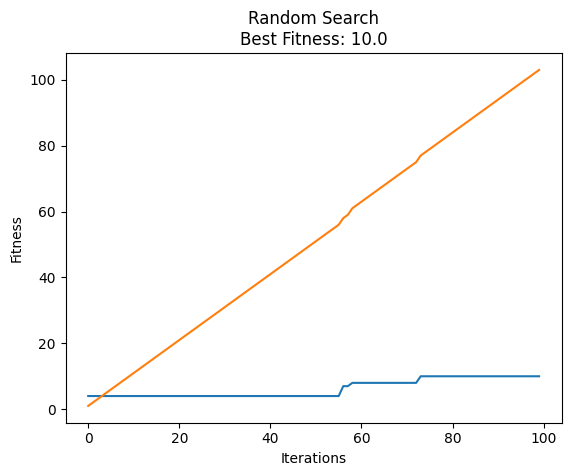

In [57]:
for algorithm in algorithms:
    print(algorithm["name"])
    print(algorithm["search_space"])
    
    # Define problem
    problem = mlrose.DiscreteOpt(
        length=algorithm["search_space"]["length"],
        fitness_fn=algorithm["fitness_function"],
        maximize=True
    )
    
    # Run optimization
    best_state, best_fitness, fitness_curve = algorithm["function"](
        problem=problem,
        **algorithm["kwargs"]
    )
    # Plot fitness curve
    plt.plot(fitness_curve)
    plt.title(f"{algorithm['name']}\nBest Fitness: {best_fitness}")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    plt.show()

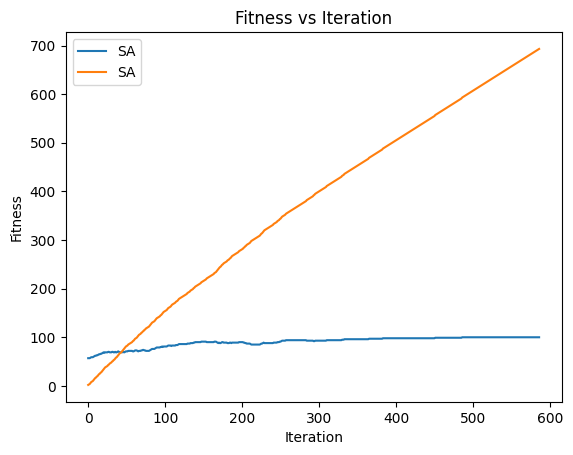

In [58]:
# Define the optimization problem
problem = mlrose.DiscreteOpt(length=100, fitness_fn=mlrose.OneMax(), maximize=True, max_val=2)

# Define the schedule
schedule = mlrose.ExpDecay()

# Run the simulated annealing algorithm and get the best solution and fitness curve
best_state, best_fitness, best_fitness_curve = mlrose.simulated_annealing(problem, schedule=schedule, max_attempts=100,
                                                                          max_iters=1000, curve=True, random_state=42)

# Plot the fitness curve
plt.plot(best_fitness_curve, label="SA")
plt.title("Fitness vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()
plt.show()

